In [2]:
!unzip -u "/content/drive/MyDrive/Computer Vision/Dataset_Emotion_Recognition.zip" -d "/content/drive/MyDrive/Computer Vision/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3829.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_383.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3830.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3831.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3832.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3833.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3834.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3835.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3836.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/train_sad_3837.jpg  
 extracting: /content/drive/MyDrive/Computer Vision/data/train/sad/tra

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers , layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
import PIL
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
from sklearn.metrics import classification_report, accuracy_score

In [6]:
image_gen= ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2,
    validation_split = 0.2
) 
test_gen=ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
) 

In [7]:
train_path="/content/drive/MyDrive/Computer Vision/data/train"
test_path="/content/drive/MyDrive/Computer Vision/data/test"

In [30]:
img_height,img_width=48,48
batch_size=200
train_ds = image_gen.flow_from_directory(
  train_path,
  shuffle=True,
  subset="training",
  seed=123,
  class_mode='categorical',
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 23059 images belonging to 7 classes.


In [31]:
valid_ds = image_gen.flow_from_directory(
  train_path,
  shuffle=True,
  subset="validation",
  seed=123,
  class_mode='categorical',
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 5761 images belonging to 7 classes.


In [32]:
test_ds=test_gen.flow_from_directory(
  test_path,
  shuffle=True,
  seed=123,
  class_mode='categorical',
  target_size=(img_height, img_width),
  batch_size=batch_size)

Found 7066 images belonging to 7 classes.


Found 28820 files belonging to 7 classes.


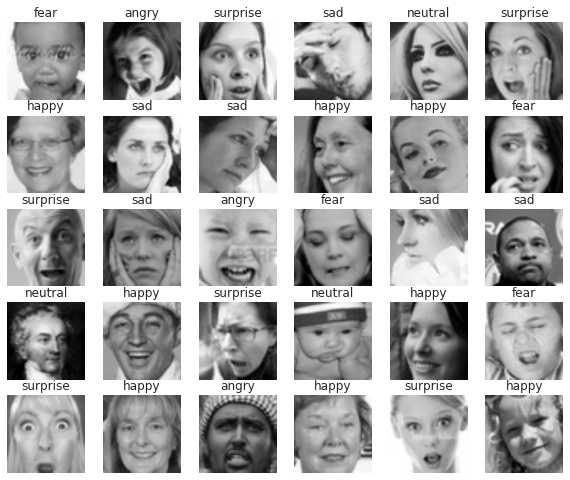

In [33]:
plt.figure(figsize=(10, 10))

train_sm = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Computer Vision/data/train')
class_names = train_sm.class_names

for images, labels in train_sm.take(1):
    for i in range(30):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


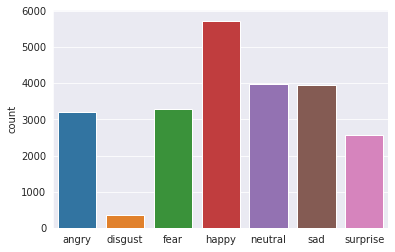

In [34]:
class_names = {j:i for i,j in train_ds.class_indices.items()}
classes = [class_names[i] for i in train_ds.classes]
sns.countplot(classes)
plt.savefig("image_{}.png".format("bar"))

In [35]:
shape = (48,48,3)
num_classes = len(set(test_ds.classes))

In [36]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return

In [37]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.threshold=threshold 
        self.factor=factor
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.initial_epoch=initial_epoch 
        best_weights=self.model.get_weights()   
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr=lr
        v_loss=logs.get('val_loss') 
        acc=logs.get('accuracy')  
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: 
            monitor='accuracy'
            if acc>self.highest_tracc:                 
                self.highest_tracc=acc 
                LRA.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [38]:
def tr_plot(tr_data, start_epoch):
   
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [39]:
epochs =10
patience= 2
stop_patience =3 
threshold=.9 
factor=.5 
dwell=True 
freeze=False

In [40]:
model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=shape, activation = "relu"),
        Conv2D(64, (3, 3), activation = "relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation = "relu"),
        Dense(num_classes, activation = "softmax")
    ])

model.compile(loss = 'categorical_crossentropy',
                  optimizer = "adam",
                  metrics = ['accuracy'])

In [42]:
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name="CNN1", freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs
history=model.fit(x=train_ds,  epochs=epochs, callbacks=callbacks, verbose=0,  validation_data=valid_ds,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model CNN1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /10     1.843   25.430   1.74570  29.127   0.00100  0.00100  accuracy   51.71  

 2 /10     1.698   32.161   1.63923  36.087   0.00100  0.00100  accuracy   42.90  

 3 /10     1.615   37.048   1.57858  38.743   0.00100  0.00100  accuracy   40.81  

 4 /10     1.556   39.807   1.52430  41.312   0.00100  0.00100  accuracy   40.12  

 5 /10     1.511   42.014   1.49086  42.423   0.00100  0.00100  accuracy   39.84  

 6 /10     1.471   43.619   1.46046  43.794   0.00100  0.00100  accuracy   39.60  

 7 /10     1.437   45.149   1.44802  44.489   0.00100  0.00100  accuracy   39.58  

 8 /10     1.406   46.129   1.42439  45.548   0.00100  0.00100  accuracy   39.55  

 9 /10     1.375   47.617   1.40463  45.496   0.00100  0.00100  accuracy   39.69  

10 /10     1.347   48.662   1.38915  47.127   0.00100  0.00100  accuracy   41.25  



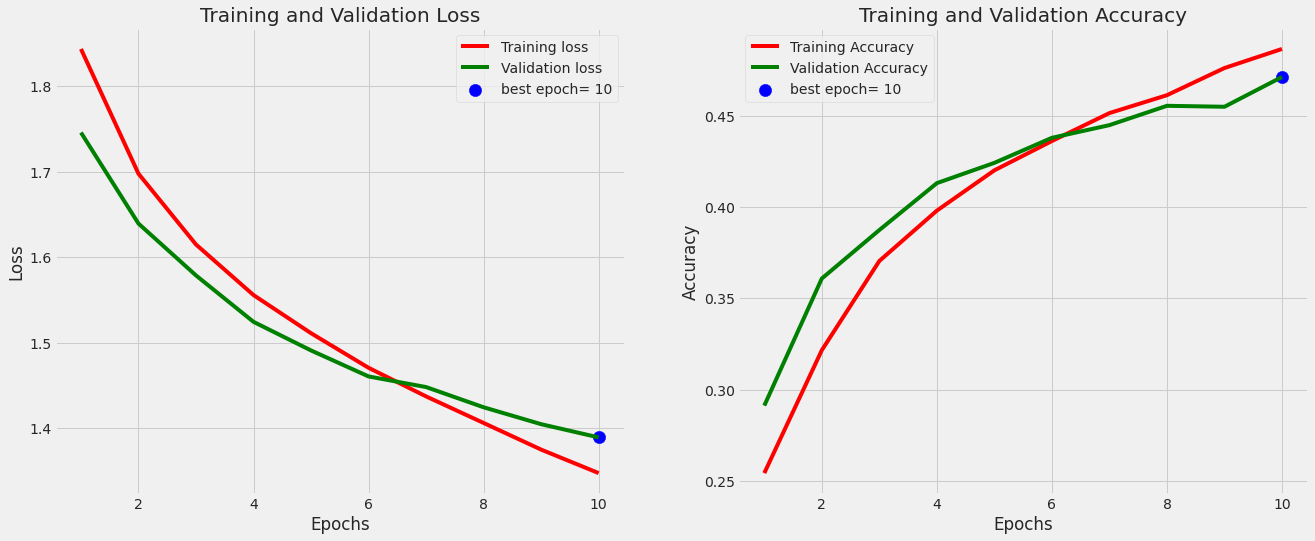

In [45]:
tr_plot(history,0)

In [59]:
train_acc=model.evaluate(train_ds)[1]*100
msg=f'accuracy on the train set is {train_acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis = 1)
y_test = test_ds.classes
acc=accuracy_score(y_test, y_pred)*100
test_msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(test_msg, (0,255,0),(55,65,80))
print(classification_report(y_test, y_pred))

116/116 [==============================] - 32s 275ms/step - loss: 1.2710 - accuracy: 0.5191
accuracy on the train set is 51.91 %

36/36 [==============================] - 10s 269ms/step
accuracy on the test set is 19.32 %

              precision    recall  f1-score   support

           0       0.13      0.07      0.09       960
           1       0.00      0.00      0.00       111
           2       0.17      0.08      0.11      1018
           3       0.26      0.35      0.30      1825
           4       0.17      0.22      0.20      1216
           5       0.17      0.18      0.18      1139
           6       0.12      0.12      0.12       797

    accuracy                           0.19      7066
   macro avg       0.15      0.15      0.14      7066
weighted avg       0.18      0.19      0.18      7066



In [49]:
model1 = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=shape, activation = "relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(128, (3, 3), padding='same', activation = "relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
       
        Conv2D(256, (3, 3), padding='same', activation = "relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
       
        Conv2D(512, (3, 3), padding='same', activation = "relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
       
        Flatten(),
        
        Dense(128, activation = "relu"),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(256, activation = "relu"),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(512, activation = "relu"),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(1024, activation = "relu"),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(num_classes, activation = "softmax")
    ])

model1.compile(loss = 'categorical_crossentropy',
                  optimizer = "rmsprop",
                  metrics = ['accuracy'])

In [50]:
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name="CNN2", freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs
history1=model1.fit(x=train_ds,  epochs=epochs, callbacks=callbacks, verbose=0,  validation_data=valid_ds,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model CNN2 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /10     2.244   20.491   1.82309  24.839   0.00100  0.00100  accuracy   49.55  

 2 /10     1.887   27.490   2.16738  15.362   0.00100  0.00100  accuracy   43.76  

 3 /10     1.638   37.183   1.93885  21.958   0.00100  0.00100  accuracy   46.07  

 4 /10     1.489   42.968   1.75108  34.074   0.00100  0.00100  accuracy   41.59  

 5 /10     1.393   47.027   1.67895  35.237   0.00100  0.00100  accuracy   43.02  

 6 /10     1.324   49.703   1.40673  49.609   0.00100  0.00100  accuracy   41.50  

 7 /10     1.259   51.932   1.33462  47.405   0.00100  0.00100  accuracy   40.66  

 8 /10     1.216   54.538   1.43646  48.221   0.00100  0.00100  accuracy   40.53  

 9 /10     1.178   55.657   1.47116  46.173   0.00100  0.00100  accuracy   41.15  

10 /10     1.137   57.357   1.72539  41.989   0.00100  0.00100  accuracy   40.73  



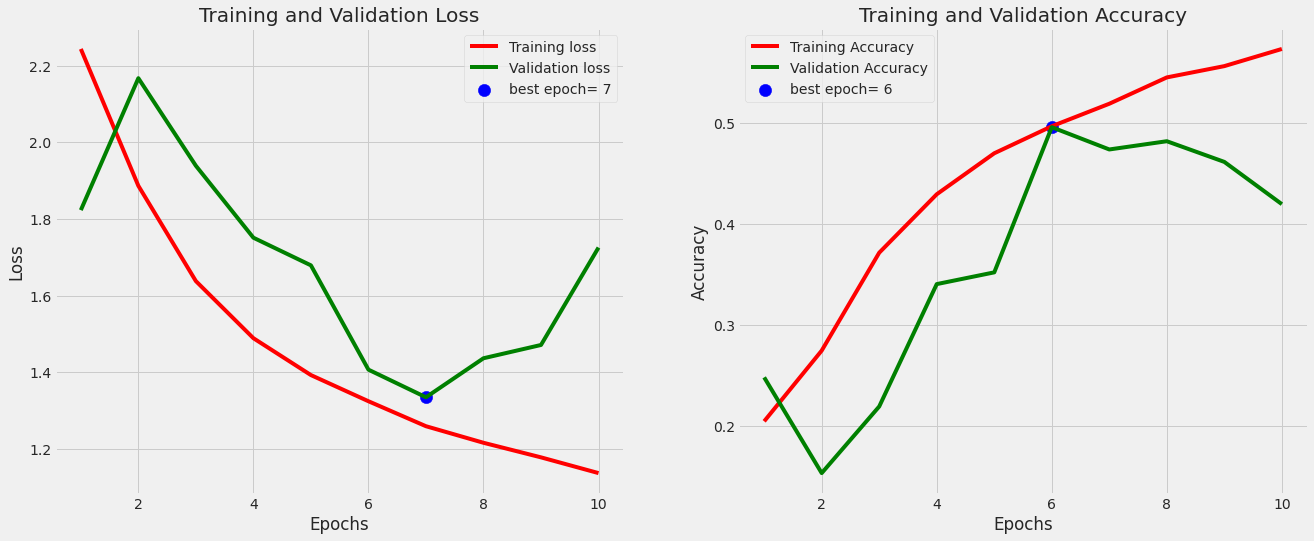

In [51]:
tr_plot(history1,0)

In [60]:
train_acc1=model1.evaluate(train_ds)[1]*100
msg1=f'accuracy on the train set is {train_acc1:5.2f} %'
print_in_color(msg1, (0,255,0),(55,65,80))
y_pred1 = model1.predict(test_ds)
y_pred1 = np.argmax(y_pred1, axis = 1)
y_test = test_ds.classes
acc1=accuracy_score(y_test, y_pred1)*100
test_msg1=f'accuracy on the test set is {acc1:5.2f} %'
print_in_color(test_msg1, (0,255,0),(55,65,80))
print(classification_report(y_test, y_pred1))

116/116 [==============================] - 32s 279ms/step - loss: 1.6231 - accuracy: 0.4503
accuracy on the train set is 45.03 %

36/36 [==============================] - 10s 273ms/step
accuracy on the test set is 16.44 %

              precision    recall  f1-score   support

           0       0.12      0.05      0.07       960
           1       0.03      0.01      0.01       111
           2       0.15      0.09      0.11      1018
           3       0.26      0.12      0.17      1825
           4       0.16      0.28      0.21      1216
           5       0.16      0.34      0.21      1139
           6       0.11      0.08      0.09       797

    accuracy                           0.16      7066
   macro avg       0.14      0.14      0.13      7066
weighted avg       0.17      0.16      0.15      7066



In [55]:
from keras.applications.densenet import DenseNet121
base_model2 = DenseNet121(input_shape=(48, 48, 3), weights='imagenet', pooling="avg", include_top=False)
x2=base_model2.output
x2=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x2)
x2 = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x2)
x2=Dropout(rate=.45, seed=123)(x2)        
output2=Dense(num_classes, activation='softmax')(x2)
model2=Model(inputs=base_model2.input, outputs=output2)
model2.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [56]:
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name="DenseNet121", freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs
history2=model2.fit(x=train_ds,  epochs=epochs, callbacks=callbacks, verbose=0,  validation_data=valid_ds,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model DenseNet121 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /10     5.641   36.641   4.07597  40.913   0.00100  0.00100  accuracy   65.60  

 2 /10     3.329   48.454   2.95148  47.006   0.00100  0.00100  accuracy   87.36  

 3 /10     2.519   52.240   2.34501  52.092   0.00100  0.00100  accuracy   42.77  

 4 /10     2.033   54.950   1.98122  52.491   0.00100  0.00100  accuracy   42.10  

 5 /10     1.710   57.748   1.77613  53.810   0.00100  0.00100  accuracy   42.21  

 6 /10     1.496   60.202   1.50628  57.021   0.00100  0.00100  accuracy   42.79  

 7 /10     1.350   61.755   1.43673  54.956   0.00100  0.00100  accuracy   42.36  

 8 /10     1.249   63.520   1.35591  57.421   0.00100  0.00100  accuracy   42.40  

 9 /10     1.165   65.150   1.31190  57.299   0.00100  0.00100  accuracy   47.80  

10 /10     1.094   67.132   1.29795  58.705   0.00100  0.00100  accuracy   42.38  



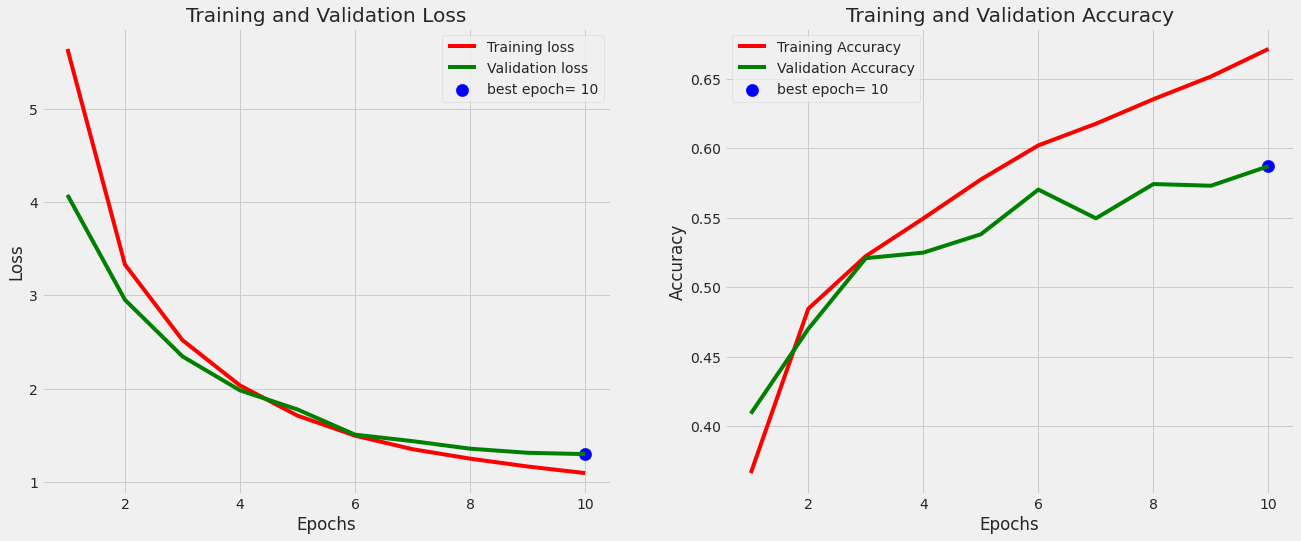

In [57]:
tr_plot(history2,0)

In [61]:
train_acc2=model2.evaluate(train_ds)[1]*100
msg2=f'accuracy on the train set is {train_acc2:5.2f} %'
print_in_color(msg2, (0,255,0),(55,65,80))
y_pred2 = model2.predict(test_ds)
y_pred2 = np.argmax(y_pred2, axis = 1)
y_test = test_ds.classes
acc2=accuracy_score(y_test, y_pred2)*100
test_msg2=f'accuracy on the test set is {acc2:5.2f} %'
print_in_color(test_msg2, (0,255,0),(55,65,80))
print(classification_report(y_test, y_pred2))

116/116 [==============================] - 33s 284ms/step - loss: 1.0772 - accuracy: 0.6765
accuracy on the train set is 67.65 %

36/36 [==============================] - 10s 273ms/step
accuracy on the test set is 18.77 %

              precision    recall  f1-score   support

           0       0.12      0.11      0.11       960
           1       0.00      0.00      0.00       111
           2       0.15      0.11      0.13      1018
           3       0.26      0.31      0.29      1825
           4       0.19      0.25      0.21      1216
           5       0.17      0.13      0.15      1139
           6       0.12      0.11      0.11       797

    accuracy                           0.19      7066
   macro avg       0.14      0.15      0.14      7066
weighted avg       0.18      0.19      0.18      7066

